# Hidden Markov Model Analysis

This notebook tries to find if there are similarities in shopper behaviour using network analysis.

## Load dependencies

In [1]:
import pandas as pd
import numpy as np
import copy

from scipy import stats

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
matplotlib.style.use('ggplot')

import seaborn as sns

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from msci.utils import utils
from msci.analysis.networks import *
from msci.utils.plot import create_count_of_shoppers_gif, create_count_of_shoppers_image
from msci.utils.plot import plot_path_jn, plot_histogram_jn, plot_points_on_map_jn

## Get data

In [4]:
mac_address_df = utils.import_mac_addresses(version=3)
signal_df = utils.import_signals(version=4)

c:\users\tvb\envs\venv-msci\lib\site-packages\IPython\core\interactiveshell.py:2850: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [5]:
shopper_df = mac_address_df[mac_address_df.dbscan_label == 'Shopper']

In [6]:
shop_df = utils.import_shop_directory(mall='Mall of Mauritius', version=2)

## Hidden Markov Model

In [7]:
from hmmlearn import hmm
from sklearn import preprocessing

In [8]:
clean_signal_shop_df = signal_df[signal_df.store_id.notnull() & (signal_df.store_id.str[0] == 'B')]
signal_mac_group = clean_signal_shop_df.groupby('mac_address')
shopper_in_signal_df = shopper_df[shopper_df.mac_address.isin(clean_signal_shop_df.mac_address.tolist())]

In [9]:
Y_dHMM = np.array([])
lengths = []

for i in range(len(shopper_in_signal_df)):
    seq = signal_mac_group.get_group(shopper_in_signal_df.mac_address.tolist()[i]).store_id.as_matrix()
    lengths.append(len(seq))
    Y_dHMM = np.concatenate([Y_dHMM, seq])
    
lengths = np.array(lengths)

In [10]:
le = preprocessing.LabelEncoder()
le.fit(Y_dHMM)
le_Y_dHMM = le.transform(Y_dHMM)

In [11]:
model = hmm.MultinomialHMM(n_components=2)

model.fit(le_Y_dHMM[:, np.newaxis], lengths=lengths)

print(model.transmat_)
print(model.emissionprob_)
print(model.startprob_)

[[ 0.92826878  0.07173122]
 [ 0.08390089  0.91609911]]
[[  6.36651254e-03   7.32670752e-03   2.43586828e-02   1.79962865e-03
    2.14450265e-02   3.35008164e-04   8.41437795e-03   2.76576316e-03
    2.98508295e-03   5.13767136e-03   5.12708016e-03   1.64351962e-03
    1.05291440e-03   2.49682102e-03   2.48382078e-03   1.24173020e-02
    3.52307248e-03   1.02470017e-03   1.18239980e-03   4.08218131e-03
    5.33651581e-03   8.31433346e-04   1.68616223e-03   7.07546293e-03
    1.00718563e-03   1.14153854e-03   5.92693117e-03   2.04548276e-03
    1.49313131e-03   7.50688145e-03   2.66474153e-03   2.71878388e-03
    1.16316127e-03   5.04922596e-03   1.07907479e-02   7.18079002e-03
    9.63231341e-04   1.37924325e-03   2.01599393e-02   5.90655468e-04
    1.11544347e-04   1.12488993e-03   1.10674639e-03   1.53118518e-04
    2.52906820e-04   6.56516866e-04   4.50803310e-04   7.00191576e-03
    1.28857614e-03   7.46956832e-03   1.16921920e-03   3.44243325e-03
    9.52710750e-05   1.98831770e-03

In [12]:
macs_predictions = model.predict(le_Y_dHMM[:, np.newaxis], lengths=lengths)

start_index = 0

hmm_probs = []

for l_i in range(len(lengths)):
    mac_predictions = macs_predictions[start_index:start_index+lengths[l_i]]
    mac_prediciton = max(mac_predictions)
    hmm_probs.append(mac_prediciton)
    start_index += lengths[l_i]
    

In [13]:
shopper_in_signal_df['hmm_probs'] = hmm_probs

c:\users\tvb\envs\venv-msci\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## Distributions

In [14]:
shopper1 = shopper_in_signal_df[shopper_in_signal_df.hmm_probs == 1].mac_address.tolist()
shopper2 = shopper_in_signal_df[shopper_in_signal_df.hmm_probs == 0].mac_address.tolist()

print(len(shopper1), len(shopper2))

5077 3637


c:\users\tvb\envs\venv-msci\lib\site-packages\pandas\core\generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
c:\users\tvb\envs\venv-msci\lib\site-packages\pandas\core\generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


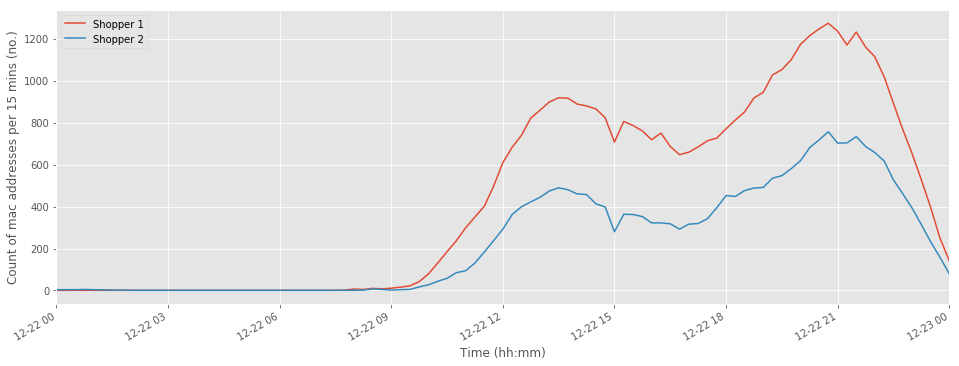

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))



plot_histogram_jn(
    signal_df[signal_df.mac_address.isin(shopper1)], 
    axes=ax,
    label='Shopper 1',
);



plot_histogram_jn(
    signal_df[signal_df.mac_address.isin(shopper2)], 
    axes=ax,
    label='Shopper 2',
);

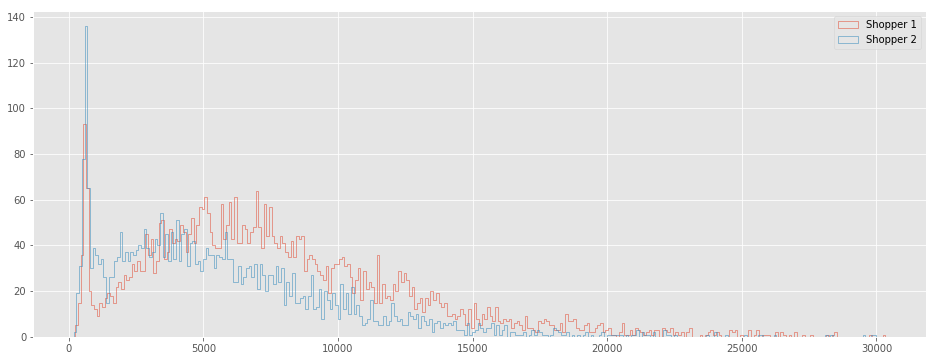

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))

binwidth = 100

data = shopper_df[shopper_df.mac_address.isin(shopper1)].length_of_stay
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='Shopper 1')

data = shopper_df[shopper_df.mac_address.isin(shopper2)].length_of_stay
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='Shopper 2')

ax.legend();

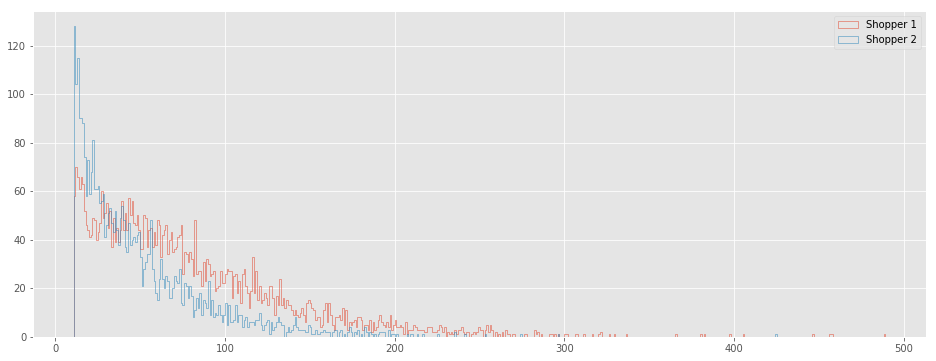

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))

binwidth = 1

data = shopper_df[shopper_df.mac_address.isin(shopper1)].frequency
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='Shopper 1')

data = shopper_df[shopper_df.mac_address.isin(shopper2)].frequency
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='Shopper 2')

ax.legend();

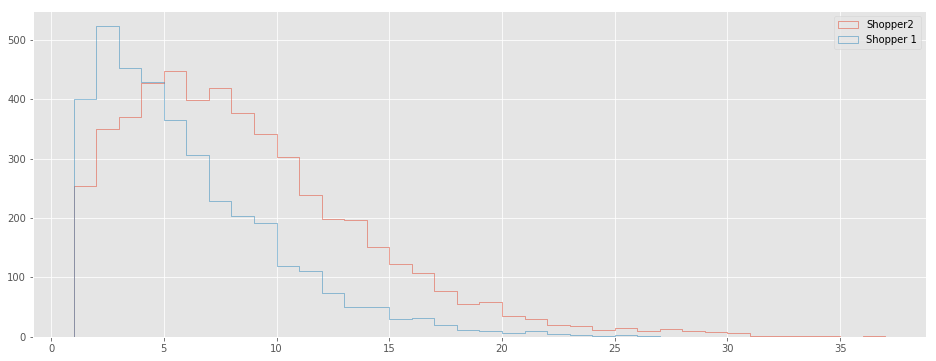

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))

binwidth = 1

data = shopper_df[shopper_df.mac_address.isin(shopper1)].number_of_shops.as_matrix()
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='Shopper2');

data = shopper_df[shopper_df.mac_address.isin(shopper2)].number_of_shops.as_matrix()
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='Shopper 1');

ax.legend();

In [19]:
FEATURE_LIST = [
    'length_of_stay',
    'radius_of_gyration',
    'count_density_variance',
    'av_speed',
    'av_turning_angle',
    'av_path_length',
    'av_straightness',
    'turning_angle_density',
]

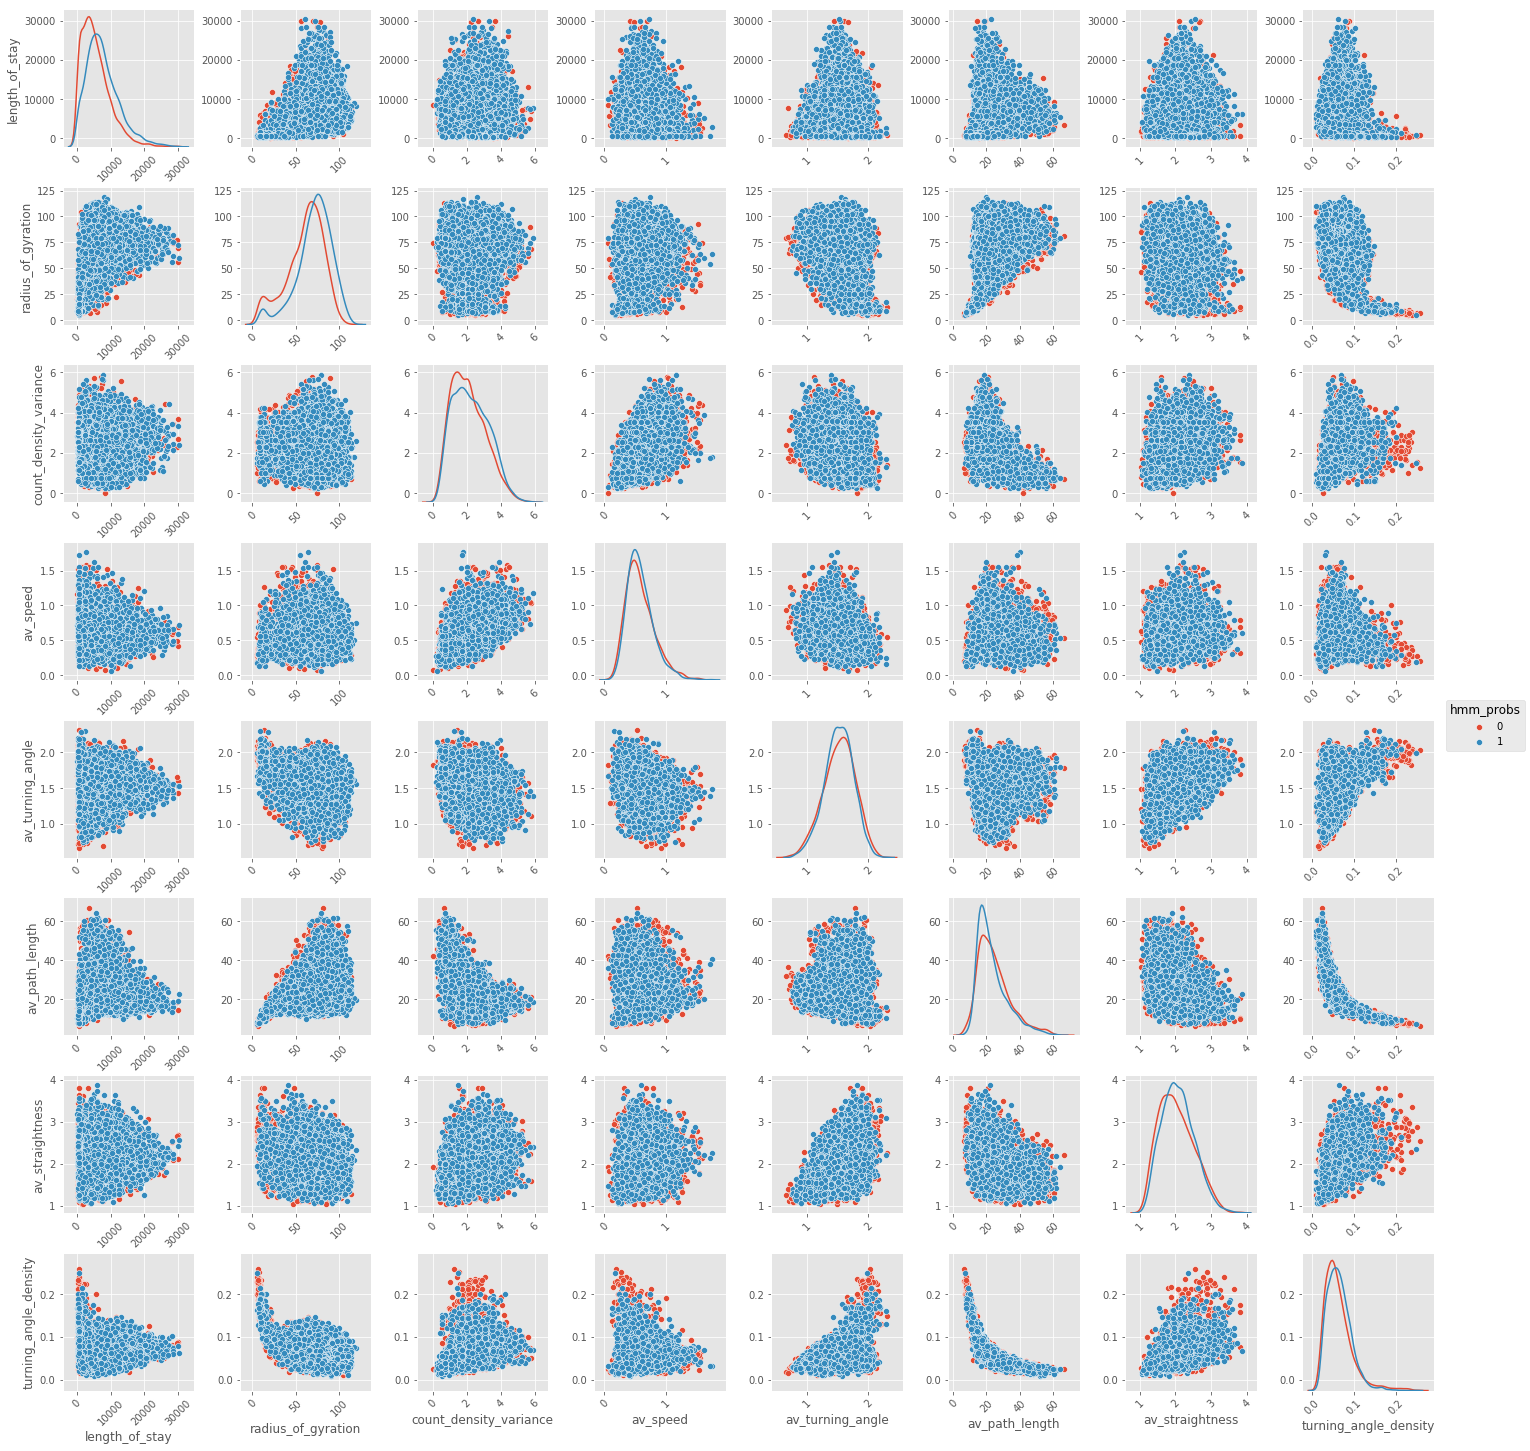

In [20]:
g = sns.pairplot(
    shopper_in_signal_df,
    vars=FEATURE_LIST,
    hue="hmm_probs", diag_kind="kde", dropna=True
)
 
for ax in g.axes.flat: 
    plt.setp(ax.get_xticklabels(), rotation=45)

## Maps

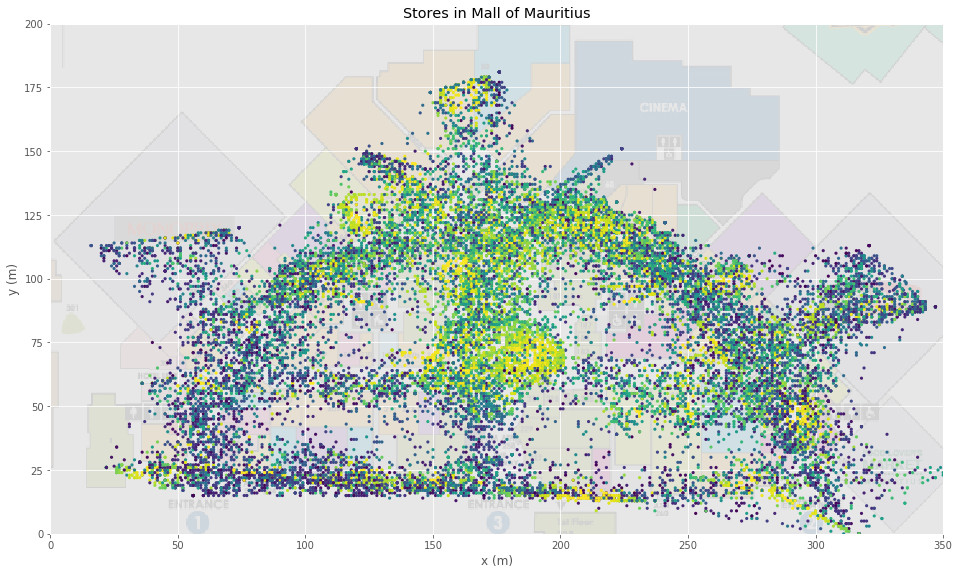

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))

plot_path_jn(
    signal_df, 
    shopper1[:100],
    axes=ax, 
    plot_type='density', 
    label=False
)

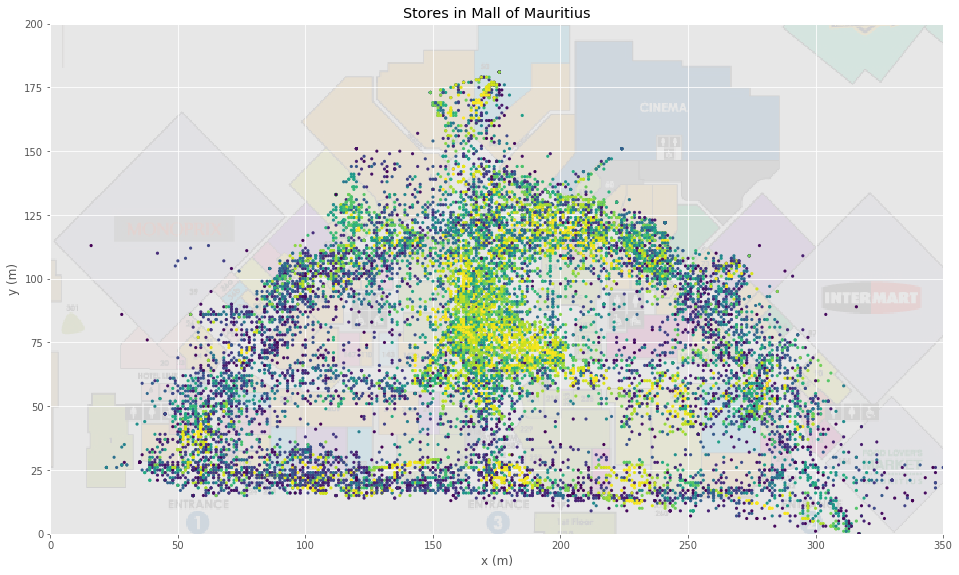

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))

plot_path_jn(
    signal_df, 
    shopper2[:100],
    axes=ax, 
    plot_type='density', 
    label=False
)

## Shops visited

In [23]:
number_of_shop = 10

shop_index = model.emissionprob_[0].argsort()[-number_of_shop:][::-1]
shops1 = le.inverse_transform(shop_index)

shop_index = model.emissionprob_[1].argsort()[-number_of_shop:][::-1]
shops2 = le.inverse_transform(shop_index)

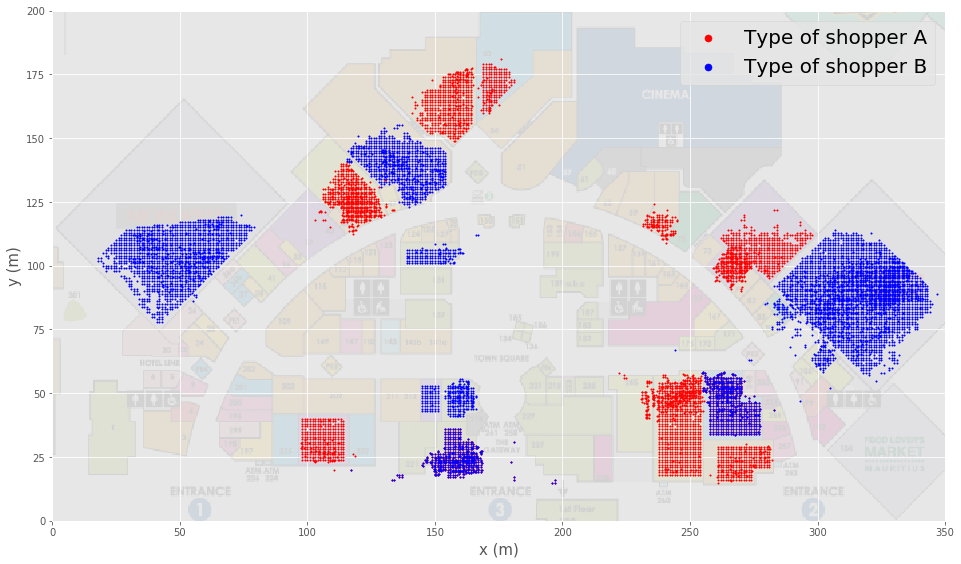

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))

x = signal_df[signal_df.store_id.isin(shops1)].drop_duplicates(['x', 'y'])[['x', 'y']].as_matrix()[:, 0]
y = signal_df[signal_df.store_id.isin(shops1)].drop_duplicates(['x', 'y'])[['x', 'y']].as_matrix()[:, 1]
plot_points_on_map_jn(x, y, axes=ax, c='r', label='Type of shopper A')

x = signal_df[signal_df.store_id.isin(shops2)].drop_duplicates(['x', 'y'])[['x', 'y']].as_matrix()[:, 0]
y = signal_df[signal_df.store_id.isin(shops2)].drop_duplicates(['x', 'y'])[['x', 'y']].as_matrix()[:, 1]
plot_points_on_map_jn(x, y, axes=ax, c='b', label='Type of shopper B')

ax.legend(markerscale=5., fontsize=20)

# fig.savefig('hmm_shopper_cluster_map.png', format='png', transparent=True, dpi=500)